In [1]:
import re
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import gensim
import nltk
import math
import seaborn as sns
from tqdm import tqdm
from sklearn.cluster import KMeans
import warnings

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

In [2]:
#!pip install gensim

In [3]:
df = pd.read_csv('spam_ham_dataset.csv')
df1 = pd.read_csv('spam.csv',encoding = "ISO-8859-1")

In [4]:
df1.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
# Print the shape of df and df1
print('df shape:', df.shape)
print('df1 shape:', df1.shape)

# Print a line of equal signs for separation
print('='*50)

# Print information about df
df.info()

# Print a line of equal signs for separation
print('='*50)

# Print information about df1
df1.info()


df shape: (5171, 4)
df1 shape: (5572, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [6]:
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


Dropping redundant columns

In [7]:
# Remove 'Unnamed: 0' and 'label_num' columns from df
df.drop(['Unnamed: 0', 'label_num'], axis=1, inplace=True)

# Remove 'Unnamed: 2', 'Unnamed: 3', and 'Unnamed: 4' columns from df1
df1.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)


In [8]:
# Rename columns of dataframes and display first few rows of one of them
col_names = ['label', 'text']
df.columns = col_names
df1.columns = col_names
df.head()


,label,text
0,ham,Subject: enron methanol ; meter # : 988291\r\n...
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see..."
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar..."
3,spam,"Subject: photoshop , windows , office . cheap ..."
4,ham,Subject: re : indian springs\r\nthis deal is t...


In [9]:
df1.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
# Print a line of equal signs for visual separation
print('='*30)

# Check for null values in dataframe df and print results
print('df Null Value checking:\n', df.isnull().sum())

# Print another line of equal signs for visual separation
print('='*30)

# Check for null values in dataframe df1 and print results
print('df1 Null Value checking:\n', df1.isnull().sum())


df Null Value checking:
 label    0
text     0
dtype: int64
df1 Null Value checking:
 label    0
text     0
dtype: int64


**Encoding the Labels**

In [11]:
# Initialize a LabelEncoder object
le = LabelEncoder()

# Use the LabelEncoder object to transform the 'label' column of the 'df' DataFrame
df['label'] = le.fit_transform(df['label'])

# Use the LabelEncoder object to transform the 'label' column of the 'df1' DataFrame
df1['label'] = le.fit_transform(df1['label'])


**Preprocessing**

![Preprocessing](https://www.shutterstock.com/image-vector/filtering-data-illustration-concept-vector-260nw-2065963628.jpg)

In [12]:
# Remove 'Subject:' from the beginning of each email's text
import re
def remove_subject(text: str) -> str:
    """
    Remove the 'Subject:' prefix from the email's text.

    Parameters:
    text (str): The email's text.

    Returns:
    str: The email's text with 'Subject:' prefix removed.
    """
    return re.sub('^Subject:', '', text)

df['text'] = df['text'].apply(remove_subject)


Concatination of 2 dfs

In [13]:
# Concatenate df and df1, and reset index
df2 = pd.concat([df, df1])
df2.reset_index(drop=True, inplace=True)

# Display the value counts of the 'label' column
df2.label.value_counts()


0    8497
1    2246
Name: label, dtype: int64

In [14]:
df2.sample(5)

,label,text
5114,0,deletion of your enrononline user id\r\npassw...
1474,0,"tenaska agreement\r\ndarren ,\r\ndo you know ..."
6442,0,If you still havent collected the dough pls le...
746,0,"fw : men & cars\r\nbecause i ' m a man , when..."
7233,0,Is there any training tomorrow?


*Spam and Not spam mail count*

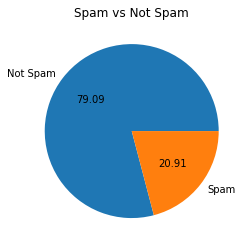

In [15]:
import matplotlib.pyplot as plt

# Create a pie chart of label value counts
plt.pie(df2.label.value_counts(), labels=['Not Spam', 'Spam'], autopct='%.2f')

# Set the title of the chart
plt.title('Spam vs Not Spam')

# Display the chart
plt.show()


**Cleanning the text**

In [16]:
# Tokenize the text in the 'text' column of df2 using gensim.utils.simple_preprocess()
# and store the result in the 'ltext' column of df2.
df2['ltext'] = df2['text'].apply(gensim.utils.simple_preprocess)
df2.head()


,label,text,ltext
0,0,enron methanol ; meter # : 988291\r\nthis is ...,"[enron, methanol, meter, this, is, follow, up,..."
1,0,"hpl nom for january 9 , 2001\r\n( see attache...","[hpl, nom, for, january, see, attached, file, ..."
2,0,"neon retreat\r\nho ho ho , we ' re around to ...","[neon, retreat, ho, ho, ho, we, re, around, to..."
3,1,"photoshop , windows , office . cheap . main t...","[photoshop, windows, office, cheap, main, tren..."
4,0,re : indian springs\r\nthis deal is to book t...,"[re, indian, springs, this, deal, is, to, book..."


**Word2Vec is a neural network model, that provides a numerical vector representation for a given word. This numerical vector is often called as "Word Embedding". Despite other methods of Bag of Words and TF-IDF, Word2Vec takes the context of the word into consideration while converting a word to a numerical vector**

In [17]:
df2['ltext_str'] = df2.ltext.apply(lambda x: ' '.join(x))

In [18]:
len(list(df2.ltext_str))

10743

In [19]:
# Check the unique values in the 'label' column of df2
print(df2['label'].unique())

df2[df2['label'] == 1]

[0 1]


,label,text,ltext,ltext_str
3,1,"photoshop , windows , office . cheap . main t...","[photoshop, windows, office, cheap, main, tren...",photoshop windows office cheap main trending a...
7,1,looking for medication ? we ` re the best sou...,"[looking, for, medication, we, re, the, best, ...",looking for medication we re the best source i...
10,1,vocable % rnd - word asceticism\r\nvcsc - bra...,"[vocable, rnd, word, asceticism, vcsc, brand, ...",vocable rnd word asceticism vcsc brand new sto...
11,1,report 01405 !\r\nwffur attion brom est inst ...,"[report, wffur, attion, brom, est, inst, siupi...",report wffur attion brom est inst siupied pgst...
13,1,vic . odin n ^ ow\r\nberne hotbox carnal brid...,"[vic, odin, ow, berne, hotbox, carnal, bride, ...",vic odin ow berne hotbox carnal bride cutworm ...
...,...,...,...,...
10708,1,Want explicit SEX in 30 secs? Ring 02073162414...,"[want, explicit, sex, in, secs, ring, now, cos...",want explicit sex in secs ring now costs min g...
10711,1,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...,"[asked, mobile, if, chatlines, inclu, in, free...",asked mobile if chatlines inclu in free mins i...
10718,1,Had your contract mobile 11 Mnths? Latest Moto...,"[had, your, contract, mobile, mnths, latest, m...",had your contract mobile mnths latest motorola...
10737,1,REMINDER FROM O2: To get 2.50 pounds free call...,"[reminder, from, to, get, pounds, free, call, ...",reminder from to get pounds free call credit a...


In [20]:
from cv2 import NBLogCount
nbl = NBLogCount(list(df2.ltext_str), list(df2.label))

                                                    text  label
0      enron methanol meter this is follow up to the ...      0
1      hpl nom for january see attached file hplnol x...      0
2      neon retreat ho ho ho we re around to that mos...      0
3      photoshop windows office cheap main trending a...      1
4      re indian springs this deal is to book the tec...      0
...                                                  ...    ...
10738  this is the nd time we have tried contact have...      1
10739                 will ì_ going to esplanade fr home      0
10740  pity was in mood for that so any other suggest...      0
10741  the guy did some bitching but acted like be in...      0
10742                          rofl its true to its name      0

[10743 rows x 2 columns]


In [21]:
import gensim
feature_size = 100

# Define Word2Vec model with specified parameters
embmodel = gensim.models.Word2Vec(
    window=10,
    min_count=3,
    workers=4,
    sg=1,
    vector_size=feature_size
)

# Build vocabulary from preprocessed text
embmodel.build_vocab(df2.ltext, progress_per=10000)

# Print corpus count and number of epochs
print(embmodel.corpus_count)
print(embmodel.epochs)

# Train the model on preprocessed text
embmodel.train(df2.ltext, total_examples=embmodel.corpus_count, epochs=embmodel.epochs)


10743
5


(3121261, 4030520)

In [22]:
# List all words in vocabulary
vocab = list(embmodel.wv.key_to_index.keys())
# Get the length of vocabulary
vocab_len = len(vocab)


In [23]:
# for word in sentence:
#     if word in vocab:
#         fit_result = nbl.fit(word)
#         if fit_result is None:
#             print(fit_result, word)
nbl.fit('monday')

15.868108515779813

In [24]:
# import pickle 
# pickle.dump(embmodel,open('embedding.pkl','wb'))

In [25]:
# pickle.dump(df2,open('Main_data.pkl','wb'))
# df2.to_csv('main_data.csv')

In [26]:
def avg_w2vec(sentence):
    """
    Calculates the average word vector for a given sentence.

    Args:
        sentence (List[str]): A list of words in a sentence.

    Returns:
        np.array: The average word vector for the given sentence.
                  If no words in the sentence are in the vocabulary, returns np.nan.
    """
    count = 0
    vector = np.zeros(feature_size)

    for word in sentence:
        if word in vocab:
            fit_result = nbl.fit(word)
            # if fit_result is not None:
            vector += embmodel.wv.get_vector(word) #* fit_result
            count += 1 # fit_result
                
    if count != 0:
        vector /= count
    else:
        return np.nan
    
    return vector


In [27]:
# np.isnan(avg_w2vec('sggb egrhb sfgdf'.split(' '))).sum()

In [28]:
df2[df2.label == 1]['ltext_str']

3        photoshop windows office cheap main trending a...
7        looking for medication we re the best source i...
10       vocable rnd word asceticism vcsc brand new sto...
11       report wffur attion brom est inst siupied pgst...
13       vic odin ow berne hotbox carnal bride cutworm ...
                               ...                        
10708    want explicit sex in secs ring now costs min g...
10711    asked mobile if chatlines inclu in free mins i...
10718    had your contract mobile mnths latest motorola...
10737    reminder from to get pounds free call credit a...
10738    this is the nd time we have tried contact have...
Name: ltext_str, Length: 2246, dtype: object

In [29]:
# Calculate the average word2vec vector for each value in the 'ltext' column of the dataframe 'df2', and store the result in a new column called 'vec_text'
df2['vec_text'] = df2.ltext.apply(avg_w2vec)

In [30]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10743 entries, 0 to 10742
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      10743 non-null  int32 
 1   text       10743 non-null  object
 2   ltext      10743 non-null  object
 3   ltext_str  10743 non-null  object
 4   vec_text   10718 non-null  object
dtypes: int32(1), object(4)
memory usage: 377.8+ KB


In [31]:
# Drop rows with null values and reset the index
df2.dropna(inplace=True)
df2.reset_index(drop=True)

,label,text,ltext,ltext_str,vec_text
0,0,enron methanol ; meter # : 988291\r\nthis is ...,"[enron, methanol, meter, this, is, follow, up,...",enron methanol meter this is follow up to the ...,"[-0.1750246809898979, -0.18521137861534953, -0..."
1,0,"hpl nom for january 9 , 2001\r\n( see attache...","[hpl, nom, for, january, see, attached, file, ...",hpl nom for january see attached file hplnol x...,"[-0.11154691570184448, -0.2007362222806974, -0..."
2,0,"neon retreat\r\nho ho ho , we ' re around to ...","[neon, retreat, ho, ho, ho, we, re, around, to...",neon retreat ho ho ho we re around to that mos...,"[-0.09741200884265812, -0.09541546094694237, -..."
3,1,"photoshop , windows , office . cheap . main t...","[photoshop, windows, office, cheap, main, tren...",photoshop windows office cheap main trending a...,"[-0.27703663233954173, 0.13187608695947206, -0..."
4,0,re : indian springs\r\nthis deal is to book t...,"[re, indian, springs, this, deal, is, to, book...",re indian springs this deal is to book the tec...,"[-0.13664612686261535, -0.08027066323056556, -..."
...,...,...,...,...,...
10713,1,This is the 2nd time we have tried 2 contact u...,"[this, is, the, nd, time, we, have, tried, con...",this is the nd time we have tried contact have...,"[-0.17462410990148783, -0.1602917899377644, -0..."
10714,0,Will Ì_ b going to esplanade fr home?,"[will, ì_, going, to, esplanade, fr, home]",will ì_ going to esplanade fr home,"[0.01834302009748561, -0.01560907278742109, -0..."
10715,0,"Pity, * was in mood for that. So...any other s...","[pity, was, in, mood, for, that, so, any, othe...",pity was in mood for that so any other suggest...,"[0.04828500457935863, -0.08549740496608946, -0..."
10716,0,The guy did some bitching but I acted like i'd...,"[the, guy, did, some, bitching, but, acted, li...",the guy did some bitching but acted like be in...,"[-0.08939174477658841, -0.07176599775139829, -..."


In [32]:
df2.head(5)

,label,text,ltext,ltext_str,vec_text
0,0,enron methanol ; meter # : 988291\r\nthis is ...,"[enron, methanol, meter, this, is, follow, up,...",enron methanol meter this is follow up to the ...,"[-0.1750246809898979, -0.18521137861534953, -0..."
1,0,"hpl nom for january 9 , 2001\r\n( see attache...","[hpl, nom, for, january, see, attached, file, ...",hpl nom for january see attached file hplnol x...,"[-0.11154691570184448, -0.2007362222806974, -0..."
2,0,"neon retreat\r\nho ho ho , we ' re around to ...","[neon, retreat, ho, ho, ho, we, re, around, to...",neon retreat ho ho ho we re around to that mos...,"[-0.09741200884265812, -0.09541546094694237, -..."
3,1,"photoshop , windows , office . cheap . main t...","[photoshop, windows, office, cheap, main, tren...",photoshop windows office cheap main trending a...,"[-0.27703663233954173, 0.13187608695947206, -0..."
4,0,re : indian springs\r\nthis deal is to book t...,"[re, indian, springs, this, deal, is, to, book...",re indian springs this deal is to book the tec...,"[-0.13664612686261535, -0.08027066323056556, -..."


In [33]:
# Importing the StandardScaler class from the sklearn.preprocessing module
from sklearn.preprocessing import StandardScaler
# Creating an instance of the StandardScaler class
scl = StandardScaler()

In [34]:
# Splitting the data into train and test sets, and scaling the features

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df2['vec_text']
y = df2['label']

X = np.vstack(X.values)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=109)

scl = StandardScaler()
X_train_scaled = scl.fit_transform(X_train)
X_test_scaled = scl.transform(X_test)

# Printing the shapes of the scaled datasets and the labels
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train_scaled shape: (7181, 100)
X_test_scaled shape: (3537, 100)
y_train shape: (7181,)
y_test shape: (3537,)


In [53]:
np.savetxt('matrix.csv', X_train_scaled, delimiter=',')

# ML Algorithm

In [54]:
# !pip install xgboost

In [55]:
# Import statements
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

In [56]:
# Initialize classifiers
svc = SVC(kernel='rbf', gamma=0.01, C=10)
knc = KNeighborsClassifier(n_neighbors=10)
gnb = GaussianNB()
dtc = DecisionTreeClassifier(criterion='entropy', max_depth=50, splitter='random')
lrc = LogisticRegression(C=500, solver='newton-cg', penalty='l2')
rfc = RandomForestClassifier(bootstrap=True, n_estimators=50, max_depth=50,max_leaf_nodes=100)
abc = AdaBoostClassifier(n_estimators=50)
bc = BaggingClassifier(n_estimators=150)
etc = ExtraTreesClassifier(n_estimators=100)
gbdt = GradientBoostingClassifier(n_estimators=100)
xgb = XGBClassifier(n_estimators = 50)

In [57]:
clfs = {
    'SVC': svc,
    'KN': knc,
    'GNB': gnb,
    'DT': dtc,
    'LR': lrc,
    'RF': rfc,
    'AdaBoost': abc,
    'BgC': bc,
    'ETC': etc,
    'GBDT': gbdt,
    'XGB':xgb
}


In [58]:
def train_classifier(clf, X_train, y_train, X_test, y_test):
    """
    Train a classifier on the given training data and return the accuracy and precision on the test data.
    
    Args:
    clf: A scikit-learn classifier object.
    X_train: A 2D numpy array of shape (n_samples, n_features) representing the training data.
    y_train: A 1D numpy array of shape (n_samples,) representing the labels for the training data.
    X_test: A 2D numpy array of shape (n_samples, n_features) representing the test data.
    y_test: A 1D numpy array of shape (n_samples,) representing the labels for the test data.
    
    Returns:
    A tuple containing the accuracy and precision of the trained classifier on the test data.
    """
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test) 
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    return accuracy, precision

In [59]:
train_classifier(rfc,X_train_scaled,y_train,X_test_scaled,y_test)

(0.9488266892847046, 0.9248466257668712)

In [60]:
# Create empty lists to store accuracy and precision scores
accuracy_scores = []
precision_scores = []

# Loop through the classifiers and train them
for name, clf in clfs.items():
    current_accuracy, current_precision = train_classifier(clf, X_train_scaled, y_train, X_test_scaled, y_test)
    
    # Print the accuracy and precision scores for each classifier
    print(f'For {name}, Accuracy: {current_accuracy} and Precision: {current_precision}')
    
    # Append the accuracy and precision scores to the respective lists
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)


For SVC, Accuracy: 0.9615493355951371 and Precision: 0.9131034482758621
For KN, Accuracy: 0.9290359061351428 and Precision: 0.7807424593967517
For GNB, Accuracy: 0.8281029120723777 and Precision: 0.5494933749025721
For DT, Accuracy: 0.9123551031947978 and Precision: 0.776332899869961
For LR, Accuracy: 0.9256432004523607 and Precision: 0.8361823361823362
For RF, Accuracy: 0.9502403166525304 and Precision: 0.9319938176197836
For AdaBoost, Accuracy: 0.9338422391857506 and Precision: 0.8344459279038718
For BgC, Accuracy: 0.9567430025445293 and Precision: 0.9254385964912281
For ETC, Accuracy: 0.9609838846480068 and Precision: 0.952959028831563
For GBDT, Accuracy: 0.9522193949674865 and Precision: 0.8974719101123596
For XGB, Accuracy: 0.95787390443879 and Precision: 0.9103641456582633


In [61]:
# pickle.dump(rfc,open('RF.pkl','wb'))

In [62]:
import pandas as pd

# create a dataframe with algorithm names, accuracy scores, and precision scores
performance_df = pd.DataFrame({
    'Algorithm': clfs.keys(),
    'Accuracy': accuracy_scores,
    'Precision': precision_scores
})


In [63]:
performance_df

,Algorithm,Accuracy,Precision
0,SVC,0.961549,0.913103
1,KN,0.929036,0.780742
2,GNB,0.828103,0.549493
3,DT,0.912355,0.776333
4,LR,0.925643,0.836182
5,RF,0.950240,0.931994
6,AdaBoost,0.933842,0.834446
7,BgC,0.956743,0.925439
8,ETC,0.960984,0.952959
9,GBDT,0.952219,0.897472


In [64]:
performance_df.sort_values('Precision',ascending = False)

,Algorithm,Accuracy,Precision
8,ETC,0.960984,0.952959
5,RF,0.950240,0.931994
7,BgC,0.956743,0.925439
0,SVC,0.961549,0.913103
10,XGB,0.957874,0.910364
9,GBDT,0.952219,0.897472
4,LR,0.925643,0.836182
6,AdaBoost,0.933842,0.834446
1,KN,0.929036,0.780742
3,DT,0.912355,0.776333


In [65]:
# grid_params = { 'criterion' : ['gini','entropy','log_loss'],
#                'bootstrap' : [True,False],
#                'max_depth':[5,10,50,100],
#                'n_estimators':[100,150,200,250,500],
#                'max_features':['sqrt', 'log2'],
#                'max_leaf_nodes':[20,50,100]}
# fit_clf = RandomForestClassifier()
# clf = GridSearchCV(fit_clf, grid_params,n_jobs=-1,verbose=1)
# clf.fit(X_train_scaled,y_train)

In [66]:
# clf.best_params_

In [67]:
# clf.best_score_

In [68]:
# clf.cv_results_

In [69]:
# from sklearn.metrics import roc_curve, auc,classification_report,confusion_matrix
# train_fpr,train_tpr,thresholds=roc_curve(y_train,clf.predict_proba(X_train_transformed)[:,1])
# test_fpr,test_tpr,thresholds=roc_curve(y_test,clf.predict_proba(X_test_transformed)[:,1])

In [70]:
# clf.score(X_test_transformed,y_test)

In [71]:
# import matplotlib.pyplot as plt
# plt.plot(train_fpr,train_tpr,label="Training Accuracy="+str(round(auc(train_fpr, train_tpr),2)))
# plt.plot(test_fpr,test_tpr,label="Testing Accuracy ="+str(round(auc(test_fpr, test_tpr),2)))
# plt.scatter(train_fpr,train_tpr,label="Training Accuracy="+str(round(auc(train_fpr, train_tpr),2)))
# plt.scatter(test_fpr,test_tpr,label="Testing Accuracy ="+str(round(auc(test_fpr, test_tpr),2)))
# plt.legend()
# plt.xlabel("Thresholds")
# plt.ylabel("ACCURACY")
# plt.title("Training and Testing ROC Curves")
# plt.show()

In [72]:
# clfs.keys()

In [73]:
def prediction_calculator(clf, X_train, y_train, X_test, y_test):
    """
    Trains a classifier on the training data and predicts on the test data.

    Args:
    - clf: The classifier object to use for training and predicting.
    - X_train: The training data features.
    - y_train: The training data target labels.
    - X_test: The test data features.
    - y_test: The test data target labels.

    Returns:
    - y_pred: The predicted labels for the test data.
    """
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return y_pred


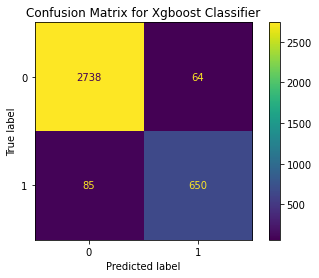

In [74]:
# Calculate predictions and plot confusion matrix for Random Forest Classifier
y_pred = prediction_calculator(clfs['XGB'], X_train_scaled, y_train, X_test_scaled, y_test)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

# Add title and show plot
plt.title('Confusion Matrix for Xgboost Classifier')
plt.show()


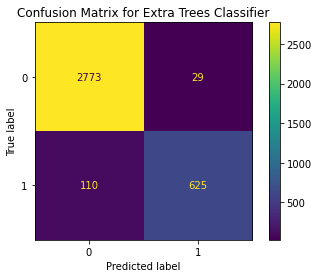

In [75]:
# Calculate predictions using Extra Trees Classifier
y_pred = prediction_calculator(clfs['ETC'], X_train_scaled, y_train, X_test_scaled, y_test)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

# Display confusion matrix with title
plt.title('Confusion Matrix for Extra Trees Classifier')
plt.show()


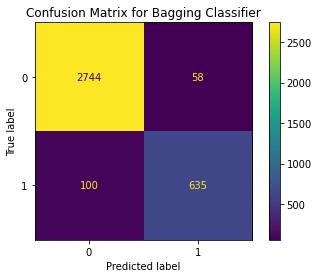

In [76]:
# Calculate prediction using Bagging Classifier
y_pred = prediction_calculator(clfs['BgC'], X_train_scaled, y_train, X_test_scaled, y_test)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title('Confusion Matrix for Bagging Classifier')
plt.show()


In [77]:
# Print classification report for predicted values using Random Forest classifier
print(classification_report(y_test, prediction_calculator(clfs['RF'], X_train_scaled, y_train, X_test_scaled, y_test)))


              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2802
           1       0.93      0.83      0.87       735

    accuracy                           0.95      3537
   macro avg       0.94      0.91      0.92      3537
weighted avg       0.95      0.95      0.95      3537



In [78]:
# Print classification report for predicted values using Extra Trees classifier
print(classification_report(y_test,prediction_calculator(clfs['ETC'],X_train_scaled,y_train,X_test_scaled,y_test)))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      2802
           1       0.96      0.86      0.91       735

    accuracy                           0.96      3537
   macro avg       0.96      0.92      0.94      3537
weighted avg       0.96      0.96      0.96      3537



In [79]:
# Print classification report for predicted values using Bagging classifier
print(classification_report(y_test,prediction_calculator(clfs['BgC'],X_train_scaled,y_train,X_test_scaled,y_test)))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2802
           1       0.92      0.86      0.89       735

    accuracy                           0.96      3537
   macro avg       0.94      0.92      0.93      3537
weighted avg       0.96      0.96      0.96      3537



# Neural Network

In [80]:
# !pip install tensorflow

In [81]:
import tensorflow as tf
from tensorflow import keras


def print_layer_output(model: keras.Model, layer_name: str, inputs: tf.Tensor) -> None:
    """
    Prints the output of a specific layer in the given model for the given inputs.
    
    Args:
    - model: keras.Model, the model that contains the layer we want to print the output for.
    - layer_name: str, the name of the layer we want to print the output for.
    - inputs: tf.Tensor, the inputs to the model.
    """
    layer_output = model.get_layer(layer_name).output
    intermediate_layer_model = keras.Model(inputs=model.input, outputs=layer_output)
    intermediate_output = intermediate_layer_model.predict(inputs)
    print(f"Output of layer {layer_name}: {intermediate_output}")
    


In [82]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import RMSprop, Adam

from rbflayer import RBFLayer, InitCentersRandom
from kmeans_initializer import InitCentersKMeans

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import LambdaCallback

In [83]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)

model = Sequential(name='ANN_Model')

model.add(Dense(5,activation='relu',input_dim = feature_size))
model.add(Dense(3,activation='relu'))
model.add(Dense(4,activation='relu'))
# model.add(Dense(1,activation='relu'))
# model.add(Dense(5,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=5,
    decay_rate=0.00000009)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss=tf.keras.losses.BinaryCrossentropy(),metrics = ['accuracy']
             )
model.summary()

Model: "ANN_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 505       
                                                                 
 dense_1 (Dense)             (None, 3)                 18        
                                                                 
 dense_2 (Dense)             (None, 4)                 16        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 544
Trainable params: 544
Non-trainable params: 0
_________________________________________________________________


In [84]:
# Create a LambdaCallback to call our custom function after each epoch
# print_callback = LambdaCallback(on_epoch_end=lambda epoch, logs: print_layer_output(model, "rbflayer", X_train_scaled))

performance = model.fit(X_train_scaled,y_train,epochs = 1000,batch_size = 10,verbose = 1,validation_split=0.35,callbacks = [callback])


Epoch 1/1000
467/467 [==============================] - 4s 5ms/step - loss: 0.5687 - accuracy: 0.8241 - val_loss: 0.3851 - val_accuracy: 0.9137
Epoch 2/1000
467/467 [==============================] - 2s 4ms/step - loss: 0.2455 - accuracy: 0.9338 - val_loss: 0.1906 - val_accuracy: 0.9308
Epoch 3/1000
467/467 [==============================] - 2s 5ms/step - loss: 0.1515 - accuracy: 0.9464 - val_loss: 0.1639 - val_accuracy: 0.9403
Epoch 4/1000
467/467 [==============================] - 3s 5ms/step - loss: 0.1303 - accuracy: 0.9516 - val_loss: 0.1556 - val_accuracy: 0.9415
Epoch 5/1000
467/467 [==============================] - 3s 6ms/step - loss: 0.1197 - accuracy: 0.9559 - val_loss: 0.1526 - val_accuracy: 0.9451
Epoch 6/1000
467/467 [==============================] - 3s 5ms/step - loss: 0.1134 - accuracy: 0.9571 - val_loss: 0.1498 - val_accuracy: 0.9491
Epoch 7/1000
467/467 [==============================] - 2s 5ms/step - loss: 0.1078 - accuracy: 0.9616 - val_loss: 0.1485 - val_accuracy:

In [85]:
# performance.history

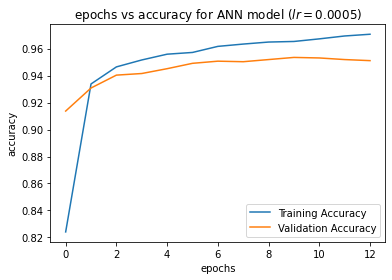

In [86]:

import matplotlib.pyplot as plt
plt.plot(performance.history['accuracy'],label='Training Accuracy')
plt.plot(performance.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('epochs vs accuracy for ANN model $(lr = 0.0005)$')
plt.legend()

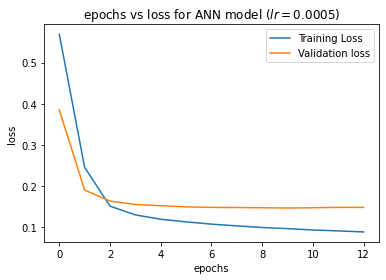

In [87]:
import matplotlib.pyplot as plt
plt.plot(performance.history['loss'],label='Training Loss')
plt.plot(performance.history['val_loss'], label = 'Validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('epochs vs loss for ANN model $(lr = 0.0005)$')
plt.legend()

In [88]:
# predictions = model.predict(X_test_scaled)
# predictions

# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn import metrics
# # y = np.array([0, 0, 1, 1])
# # pred = np.array([0.1, 0.4, 0.35, 0.8])
# fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions)
# roc_auc = metrics.auc(fpr, tpr)
# display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
#                                   estimator_name='Artificial Neural Network')
# display.plot()

# plt.show()

In [89]:
# predictions

In [90]:
# np.argmax(predictions, axis=1)

In [91]:
from keras import backend as K
from tensorflow.keras.layers import Layer
from keras.initializers import RandomUniform, Initializer, Constant
import numpy as np


# class InitCentersRandom(Initializer):
#     """ Initializer for initialization of centers of RBF network
#         as random samples from the given data set.

#     # Arguments
#         X: matrix, dataset to choose the centers from (random rows
#           are taken as centers)
#     """

#     def __init__(self, X):
#         self.X = X

#     def __call__(self, shape, dtype=None):
# 	assert shape[1] == self.X.shape[1]
#   	idx = np.random.randint(self.X.shape[0], size=shape[0])

# 	# type checking to access elements of data correctly
#   	if type(self.X) == np.ndarray:
#     		return self.X[idx, :]
#   	elif type(self.X) == pd.core.frame.DataFrame:
#     		return self.X.iloc[idx, :]


class RBFLayer(Layer):
    """ Layer of Gaussian RBF units.

    # Example

    ```python
        model = Sequential()
        model.add(RBFLayer(10,
                           initializer=InitCentersRandom(X),
                           betas=1.0,
                           input_shape=(1,)))
        model.add(Dense(1))
    ```


    # Arguments
        output_dim: number of hidden units (i.e. number of outputs of the
                    layer)
        initializer: instance of initiliazer to initialize centers
        betas: float, initial value for betas

    """

    def __init__(self, output_dim, initializer=None, betas=1.0, **kwargs):
        self.output_dim = output_dim
        self.init_betas = betas
        if not initializer:
            self.initializer = RandomUniform(0.0, 1.0)
        else:
            self.initializer = initializer
        super(RBFLayer, self).__init__(**kwargs)

    def build(self, input_shape):

        self.centers = self.add_weight(name='centers',
                                       shape=(self.output_dim, input_shape[1]),
                                       initializer=self.initializer,
                                       trainable=False)
        self.betas = self.add_weight(name='betas',
                                     shape=(self.output_dim,),
                                     initializer=Constant(
                                         value=self.init_betas),
                                     # initializer='ones',
                                     trainable=False)

        super(RBFLayer, self).build(input_shape)

    def call(self, x):

        C = K.expand_dims(self.centers)
        H = K.transpose(C-K.transpose(x))
        return K.exp(-self.betas * K.sum(H**2, axis=1))

        # C = self.centers[np.newaxis, :, :]
        # X = x[:, np.newaxis, :]

        # diffnorm = K.sum((C-X)**2, axis=-1)
        # ret = K.exp( - self.betas * diffnorm)
        # return ret

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

    def get_config(self):
        # have to define get_config to be able to use model_from_json
        config = {
            'output_dim': self.output_dim
        }
        base_config = super(RBFLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [101]:
from keras.layers import Dense, Flatten

model1 = Sequential()
model1.add(RBFLayer(2,betas=1500,initializer = InitCentersKMeans(X_train_scaled),input_shape = (100,)))
model1.add(Dense(1, activation='sigmoid', name='outer_layer'))

In [102]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rbf_layer_1 (RBFLayer)      (None, 2)                 202       
                                                                 
 outer_layer (Dense)         (None, 1)                 3         
                                                                 
Total params: 205
Trainable params: 3
Non-trainable params: 202
_________________________________________________________________


In [103]:
# model1.get_config()

In [104]:
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00051),
              loss=tf.keras.losses.BinaryCrossentropy(),metrics = ['accuracy']
             )

In [105]:
performance = model1.fit(X_train_scaled,y_train,epochs = 1000,batch_size = 5,verbose = 1,validation_split=0.15,callbacks=[callback])

Epoch 1/1000
1221/1221 [==============================] - 3s 2ms/step - loss: 0.6330 - accuracy: 0.7899 - val_loss: 0.5798 - val_accuracy: 0.8043
Epoch 2/1000
1221/1221 [==============================] - 2s 2ms/step - loss: 0.5600 - accuracy: 0.7899 - val_loss: 0.5293 - val_accuracy: 0.8043
Epoch 3/1000
1221/1221 [==============================] - 3s 2ms/step - loss: 0.5305 - accuracy: 0.7899 - val_loss: 0.5087 - val_accuracy: 0.8043
Epoch 4/1000
1221/1221 [==============================] - 2s 2ms/step - loss: 0.5195 - accuracy: 0.7899 - val_loss: 0.5004 - val_accuracy: 0.8043
Epoch 5/1000
1221/1221 [==============================] - 2s 2ms/step - loss: 0.5158 - accuracy: 0.7899 - val_loss: 0.4974 - val_accuracy: 0.8043
Epoch 6/1000
1221/1221 [==============================] - 2s 2ms/step - loss: 0.5146 - accuracy: 0.7899 - val_loss: 0.4961 - val_accuracy: 0.8043
Epoch 7/1000
1221/1221 [==============================] - 2s 2ms/step - loss: 0.5142 - accuracy: 0.7899 - val_loss: 0.4956 -

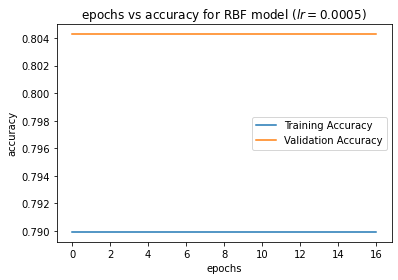

In [106]:
import matplotlib.pyplot as plt
plt.plot(performance.history['accuracy'],label='Training Accuracy')
plt.plot(performance.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('epochs vs accuracy for RBF model $(lr = 0.0005)$')
plt.legend()

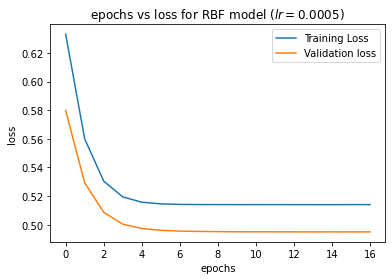

In [107]:
import matplotlib.pyplot as plt
plt.plot(performance.history['loss'],label='Training Loss')
plt.plot(performance.history['val_loss'], label = 'Validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('epochs vs loss for RBF model $(lr = 0.0005)$')
plt.legend()

111/111 [==============================] - 0s 1ms/step


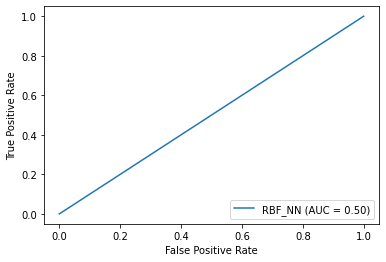

In [108]:
predictions = model1.predict(X_test_scaled)
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='RBF_NN')
display.plot()

plt.show()

111/111 [==============================] - 0s 1ms/step


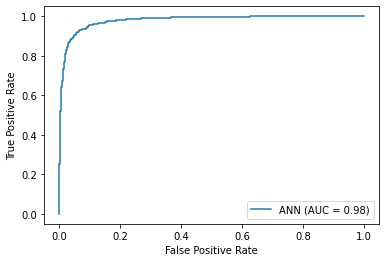

In [109]:
predictions = model.predict(X_test_scaled)
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='ANN')
display.plot()

plt.show()